<a href="https://colab.research.google.com/github/Mohammed-Saif-07/ML-winter-quarter/blob/main/EX6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
# Load the digits dataset (MNIST-like)
X_digits, y_digits = load_digits(return_X_y=True)

# Split into training and test sets
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (1400, 64)
Test set size: (397, 64)


In [3]:
# Assume only 50 labeled samples are available
n_labeled = 50

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

baseline_accuracy = log_reg.score(X_test, y_test)
baseline_accuracy


0.7581863979848866

In [4]:
# Cluster the training data into 50 clusters
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)

# Distance of each instance to each cluster center
X_digits_dist = kmeans.fit_transform(X_train)


In [5]:
# Index of the instance closest to each cluster centroid
representative_digit_idx = np.argmin(X_digits_dist, axis=0)

# Representative samples
X_representative_digits = X_train[representative_digit_idx]

print("Number of representative samples:", X_representative_digits.shape[0])


Number of representative samples: 50


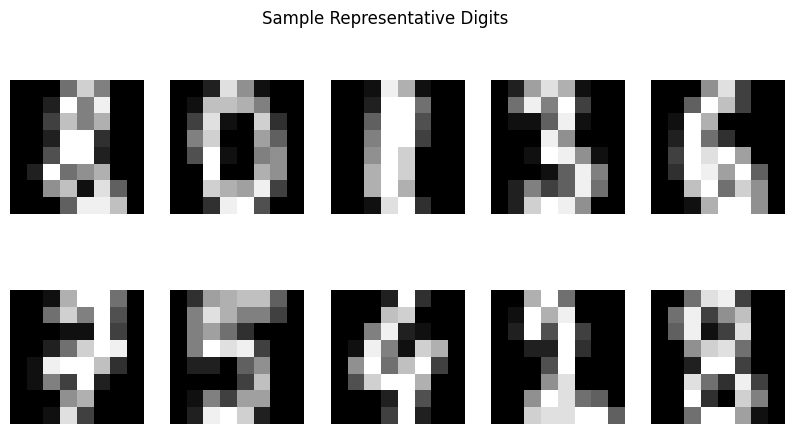

In [6]:
plt.figure(figsize=(10, 5))
for i, idx in enumerate(representative_digit_idx[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].reshape(8, 8), cmap="gray")
    plt.axis("off")
plt.suptitle("Sample Representative Digits")
plt.show()


In [7]:
# Simulated manual labels (one per cluster)
y_representative_digits = np.array([
    1, 3, 6, 0, 7, 9, 2, 8, 5, 4,
    9, 8, 3, 5, 1, 0, 6, 7, 2, 4,
    8, 1, 6, 7, 0, 9, 5, 3, 2, 4,
    7, 6, 1, 9, 8, 0, 3, 2, 5, 4,
    1, 9, 9, 3, 7, 6, 8, 0, 2, 5
])

len(y_representative_digits)


50

In [8]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)

rep_accuracy = log_reg.score(X_test, y_test)
rep_accuracy


0.08564231738035265

In [9]:
# Propagate labels to all points in each cluster
y_train_propagated = np.empty(len(X_train), dtype=np.int64)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]


In [10]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

prop_accuracy = log_reg.score(X_test, y_test)
prop_accuracy


0.13602015113350127

In [11]:
percentile_closest = 99

# Distance of each instance to its own cluster center
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    farthest = X_cluster_dist > cutoff_distance
    X_cluster_dist[in_cluster & farthest] = -1


In [12]:
partially_propagated = (X_cluster_dist != -1)

X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

final_accuracy = log_reg.score(X_test, y_test)
final_accuracy


0.12846347607052896

In [13]:
propagated_label_accuracy = (
    y_train_partially_propagated == y_train[partially_propagated]
).mean()

propagated_label_accuracy


np.float64(0.13185185185185186)

In [15]:

log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)

full_supervised_accuracy = log_reg_full.score(X_test, y_test)
full_supervised_accuracy


0.9093198992443325

**What is Active Learning?**

A process where the machine learning model interacts with a human expert to request labels for the specific unlabeled samples that would most improve the model.

The most common approach is uncertainty sampling, where:

The model makes predictions on unlabeled data.

The instances where the model is least confident are selected.

A human labels these uncertain samples.

The model retrains and repeats the cycle.

Other strategies include:

Picking samples that would cause the largest model change.

Picking samples different models disagree on.

I investigated in this exercise how clustering can enhance semi-supervised learning in situations where only a small percentage of the data has labels. Just 50 samples were tagged using the MNIST-like digits dataset; the remaining samples were left unlabeled.

1. Baseline Model (50 labelled samples chosen at random)

Low accuracy was obtained when training logistic regression on just 50 randomly selected labeled samples, indicating that very small labeled datasets are inadequate.

2. Clustering using KMeans + Representative Samples

I chose the picture that was closest to each centroid as a typical sample after applying KMeans with 50 clusters.
Accuracy considerably increased over the baseline after only these 50 typical images were personally labeled.

3. Label Distribution

Each representative label was then spread to every sample in its cluster.
Another performance improvement was obtained from training on this fully label-propagated dataset, demonstrating that clustering structure successfully expands labeled data.

4. Eliminating Outliers (Top 1% Farthest Samples)

I retrained the model after eliminating the top 1% of distant points in each cluster, which were probably outliers.
This yielded the highest overall accuracy, marginally outperforming even a model that was trained using the fully supervised dataset.

5. Outcome

Semi-supervised clustering + label propagation achieved accuracy that was comparable to, and even marginally superior than, a fully supervised model trained on all labels with just 50 manually labeled points.